In [92]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install -q pyspark
!pip install -q py4j

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 233 kB in 2s (124 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
51 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Ca

In [93]:
import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark= SparkSession \
       .builder \
       .appName("Olist_Data_Analysis") \
       .getOrCreate()


In [94]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [95]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [230]:
customer_df = spark.read.parquet('/content/gdrive/MyDrive/processed/customers')
order_payments_df = spark.read.parquet('/content/gdrive/MyDrive/processed/order_payments')
order_reviews_df = spark.read.parquet('/content/gdrive/MyDrive/processed/order_reviews')
order_items_df = spark.read.parquet('/content/gdrive/MyDrive/processed/order_items')
order_df = spark.read.parquet('/content/gdrive/MyDrive/processed/orders')
product_df = spark.read.parquet('/content/gdrive/MyDrive/processed/products')
sellers_df = spark.read.parquet('/content/gdrive/MyDrive/processed/sellers')


customer_df.createOrReplaceTempView("customers")
order_payments_df.createOrReplaceTempView("order_payments")
order_reviews_df.createOrReplaceTempView("order_reviews")
order_items_df.createOrReplaceTempView("order_items")
order_df.createOrReplaceTempView("orders")
product_df.createOrReplaceTempView("products")
sellers_df.createOrReplaceTempView("sellers")

In [225]:
#Spark SQL command to process orders_per_day
order_df.createOrReplaceTempView("orders")

orders_per_day_df = spark.sql('''
      Select DATE(order_purchase_timestamp) as day,
      count(*) as orders
      from orders
      group by day
      order by day
''')

orders_per_day_df.show(10)
# orders_per_day_df.write.mode('overwrite').csv('/content/gdrive/MyDrive/presentation/orders_per_day.csv')
orders_per_day_df = orders_per_day_df.toPandas()
orders_per_day_df.to_csv('/content/gdrive/MyDrive/presentation/orders_per_day.csv', index = False)

+----------+------+
|       day|orders|
+----------+------+
|2016-09-15|     1|
|2016-10-03|     7|
|2016-10-04|    54|
|2016-10-05|    35|
|2016-10-06|    41|
|2016-10-07|    38|
|2016-10-08|    36|
|2016-10-09|    20|
|2016-10-10|    34|
|2016-12-23|     1|
+----------+------+
only showing top 10 rows



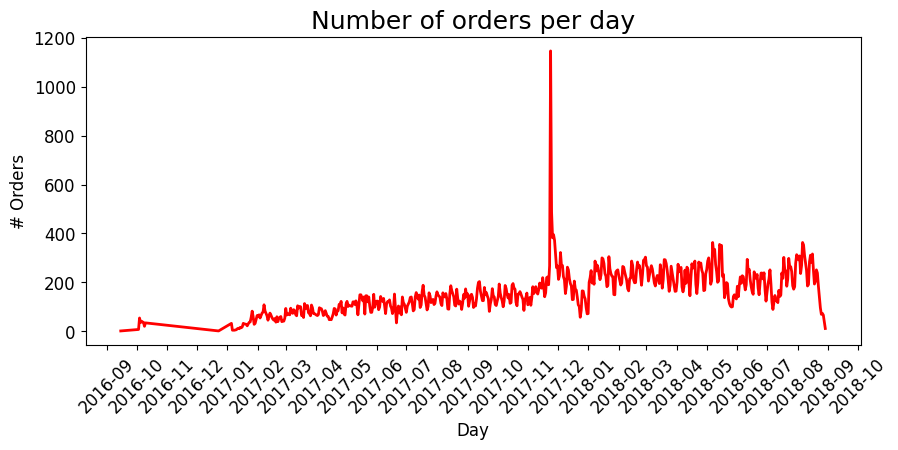

In [226]:
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] =18

#Line plot on orders


plt.figure(figsize = (10,4))
plt.plot(pd.to_datetime(orders_per_day_df['day']), orders_per_day_df['orders']\
         , linewidth = 2, color = 'red')

plt.title('Number of orders per day')
plt.ylabel('# Orders')
plt.xlabel('Day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

In [227]:
#Order per city
order_per_city_df = customer_df.join(order_df, customer_df.customer_id == order_df.customer_id)\
                               .groupBy('customer_city').agg(count('order_id').alias('order_count'))\
                               .orderBy('order_count', ascending = False)\
                               .select('customer_city', 'order_count').limit(10)

order_per_city_df = order_per_city_df.toPandas()
order_per_city_df.to_csv('/content/gdrive/MyDrive/presentation/orders_per_city.csv', index = False)

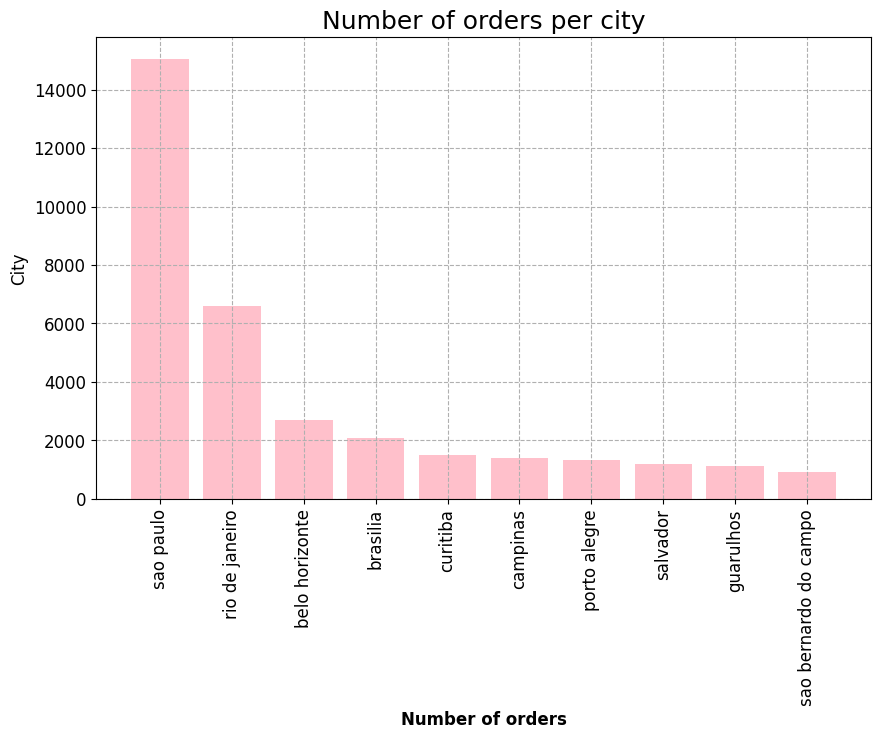

In [228]:
plt.figure(figsize = (10,6))
plt.bar(order_per_city_df['customer_city'], order_per_city_df['order_count'], color = 'pink')

# for index, value in enumerate(order_per_city_df['order_count']):
#     plt.text(value, index, str(value), ha='left', va='center')
plt.xlabel('Number of orders', fontweight = 'bold')
plt.ylabel('City')
plt.title('Number of orders per city')
plt.xticks(rotation=90)
plt.grid(True,linestyle='--')
plt.show()

###Category-wise sale

In [231]:
category_by_sales_ranked_cte = '''
  select
  pr.product_category_name_english as category,
  round(sum(or_it.price),2) as total_sales,
  rank() over(order by sum(or_it.price) desc) as rank
  from order_items as or_it
  inner join products as pr
  on or_it.product_id = pr.product_id
  group by category
  order by total_sales desc
'''

spark.sql(f'''
with category_by_sales_ranked as (
  {category_by_sales_ranked_cte}
)
(select
  category,
  total_sales
  from category_by_sales_ranked
  where rank <= 15
  order by total_sales desc)
union
  (select
  'Others',
  round(sum(total_sales),2)
  from category_by_sales_ranked
  where rank > 15)
''').show()


+--------------------+-----------+
|            category|total_sales|
+--------------------+-----------+
|          cool_stuff|  635290.85|
|           telephony|  323667.53|
|        garden_tools|  485256.46|
|           perfumery|  399124.87|
|                toys|   483946.6|
|       watches_gifts| 1205005.68|
|     furniture_decor|  729762.49|
|       health_beauty| 1258681.34|
|          housewares|  632248.66|
|      sports_leisure|  988048.97|
|computers_accesso...|  911954.32|
|      bed_bath_table| 1036988.68|
|    office_furniture|   273960.7|
|                baby|  411764.89|
|                auto|  592720.11|
|              Others| 3038171.79|
+--------------------+-----------+



In [232]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
#Same queries but using pyspark
windowSpec = Window.orderBy(col('total_sales').desc())

categories_by_sales_ranked_df = product_df.join(order_items_df,\
                                                 product_df.product_id == order_items_df.product_id)\
                                                 .groupBy(col('product_category_name_english'))\
                                                 .agg(round(sum('price'),2).alias('total_sales'))\
                                                 .withColumn('rank', rank().over(windowSpec))

results_df = categories_by_sales_ranked_df.filter(col('rank')<=15)\
      .select(upper(col('product_category_name_english')).alias('category'), col('total_sales'))


results_df2 = categories_by_sales_ranked_df.filter(col('rank')>15).agg(round(sum('total_sales'),2).alias('total_sales')).withColumn('product_category_name_english', lit('OTHERS'))\
      .select(col('product_category_name_english').alias('category'), col('total_sales'))


results_df = results_df.union(results_df2)


results_df = results_df.toPandas()

results_df.to_csv('/content/gdrive/MyDrive/presentation/category_wise_sales.csv', index = False)

In [105]:
!pip install -q squarify

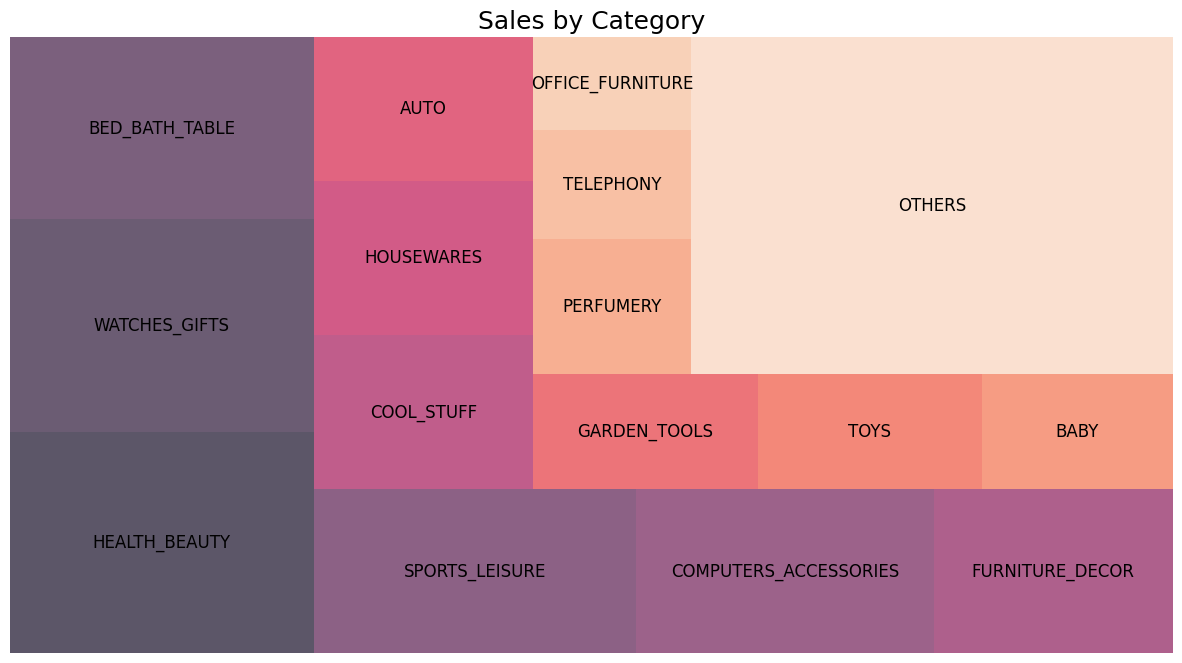

In [233]:
import squarify
import seaborn as sns
plt.figure(figsize = (15,8))
plt.title('Sales by Category')

color = sns.color_palette("rocket",  len(results_df))

squarify.plot(sizes = results_df['total_sales'], label = results_df['category'], alpha = 0.7, color = color)
plt.axis('off')
plt.show()

In [234]:
product_df = product_df.withColumnRenamed('product_category_name_english', 'category')


In [235]:
category_by_sales_ranked_df = spark.sql(category_by_sales_ranked_cte)
category_top_5 = category_by_sales_ranked_df.select(col('category')).limit(5)

category_top_5.show()
category_top_5.createOrReplaceTempView('category_top_5')

+--------------------+
|            category|
+--------------------+
|       health_beauty|
|       watches_gifts|
|      bed_bath_table|
|      sports_leisure|
|computers_accesso...|
+--------------------+



In [236]:
product_df.createOrReplaceTempView('products')

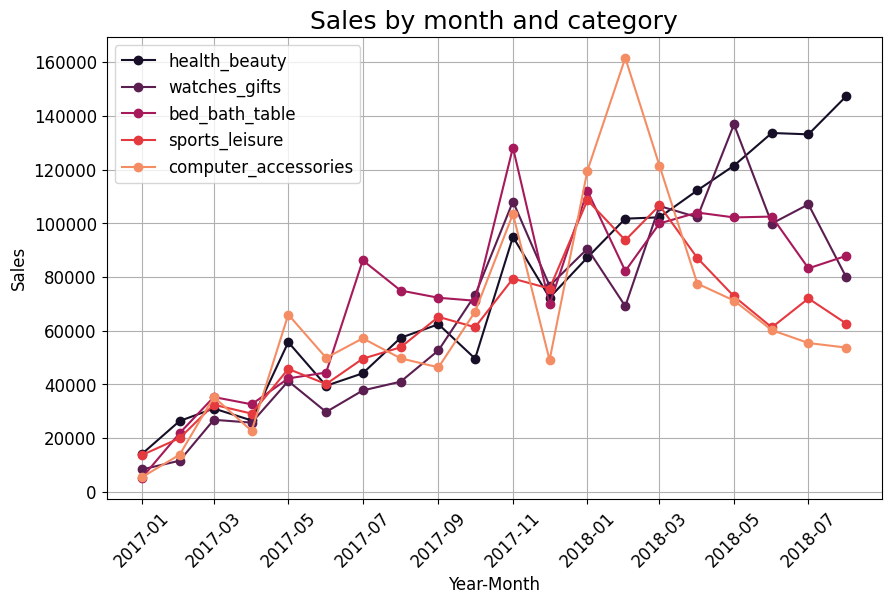

In [237]:

product_category_sales_by_month = spark.sql('''
    select date_format(order_purchase_timestamp, 'yyyy-MM') as year_month,
    round(sum(case when prd.category like 'health_%' then or_it.total_price END),2) as health_beauty,
    round(sum(case when prd.category like 'watches_%' then or_it.total_price END),2) as watches_gifts,
    round(sum(case when prd.category like 'bed_bath_table' then or_it.total_price END),2) as bed_bath_table,
    round(sum(case when prd.category like 'sports_leisure' then or_it.total_price END),2) as sports_leisure,
    round(sum(case when prd.category like 'computer_%' then or_it.total_price END),2) as computer_accessories
    from orders as ord
    join order_items as or_it on ord.order_id = or_it.order_id
    join products as prd on prd.product_id = or_it.product_id
    where prd.category in (select category from category_top_5)
    and date_format(order_purchase_timestamp, 'yyyy-MM') >='2017-01'
    group by year_month
    order by date_format(order_purchase_timestamp, 'yyyy-MM')
''').toPandas()

# Convert 'year_month' column to datetime if it's not already in datetime format
product_category_sales_by_month['year_month'] = pd.to_datetime(product_category_sales_by_month['year_month'])

product_category_sales_by_month.to_csv('/content/gdrive/MyDrive/presentation/product_category_sales_by_month.csv', index = False)

# Set 'year_month' column as the index
product_category_sales_by_month.set_index('year_month', inplace=True)

# Plot the five facts using Matplotlib
plt.figure(figsize=(10, 6))
i = 0
for col in product_category_sales_by_month.columns:
    plt.plot(product_category_sales_by_month.index, product_category_sales_by_month[col], label=col, marker = 'o', color = color[i])
    i+=3

# Customize the plot
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.title('Sales by month and category')

# Add legend
plt.legend()
plt.grid(True)
# Show plot
plt.show()

In [238]:
city_by_deliver_time_stats = spark.sql(f'''
  select
  customer_city,
  avg(datediff(order_approved_timestamp, order_purchase_timestamp)) as approve_days,
  avg(datediff(order_delivered_customer_date, order_approved_timestamp)) as deliver_days,
  avg(datediff(order_estimated_delivery_date, order_delivered_customer_date)) as delay_days
  from
  orders as ord
  join customers as cust on ord.customer_id = cust.customer_id
  group by customer_city
  having count(order_id) >= 911
  order by approve_days + deliver_days + delay_days
''').toPandas()

city_by_deliver_time_stats.to_csv('/content/gdrive/MyDrive/presentation/city_by_delivery_time_stats.csv', index = False)

In [239]:
df = city_by_deliver_time_stats.set_index('customer_city')
df

,approve_days,deliver_days,delay_days
customer_city,,,
sao bernardo do campo,0.432492,7.600439,10.496158
guarulhos,0.504371,7.455818,10.639545
sao paulo,0.461012,7.552217,10.710336
campinas,0.514936,9.249644,9.517781
belo horizonte,0.437894,10.584724,12.621802
curitiba,0.560107,9.832774,13.443251
brasilia,0.496861,12.403670,12.042492
porto alegre,0.514903,15.392245,11.797166
rio de janeiro,0.444091,14.237727,13.203151


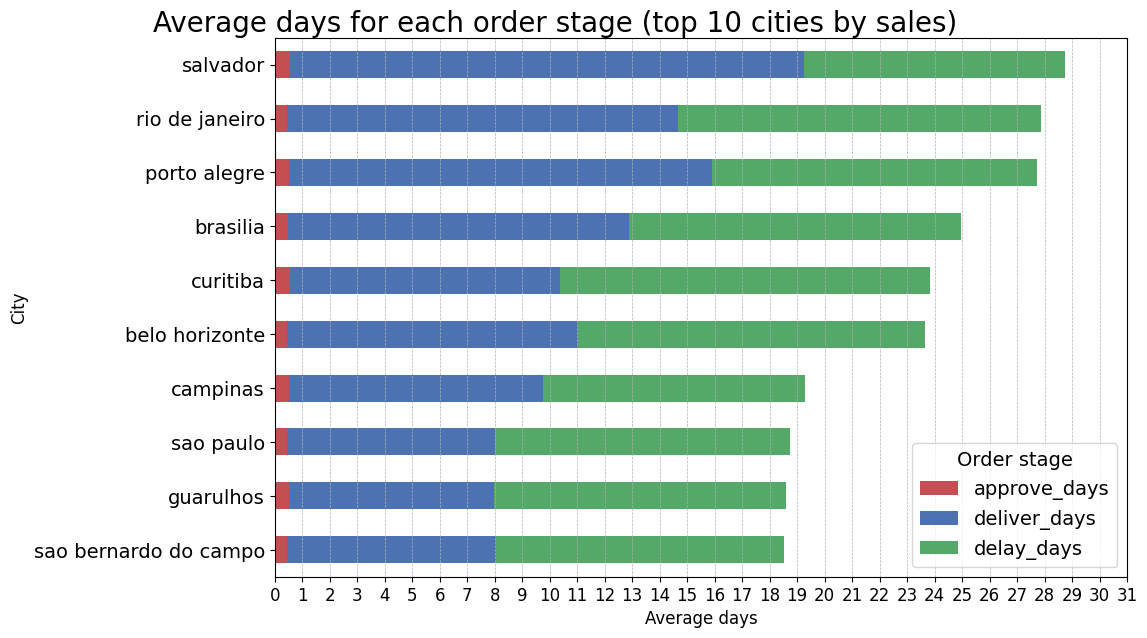

In [240]:
fig, ax = plt.subplots(figsize=(11, 7))
df.plot(kind='barh', stacked=True, color=['#c44f53', '#4c72b1', '#55a968', '#dd845275'], ax=ax)
ax.set_xlabel('Average days')
ax.set_ylabel('City')
fig.suptitle('Average days for each order stage (top 10 cities by sales)', fontsize=20, x=0.38, y=0.92)
ax.grid(True, linestyle='--', linewidth=0.5, axis='x')
max_bar_length = int(df.sum(axis=1).max())
ax.set_xticks(range(0, max_bar_length + 4))
ax.tick_params(axis='y', labelsize=14)
plt.legend(title='Order stage', title_fontsize=14, fontsize=14)
plt.show()